In [2]:
# Useful imports
import matplotlib.pylab as plt
import numpy as np
import os
import sys
import pandas as pd

Took the following datasets:

| Data file | Termination |
| --- | --- |
| [GLSD020.CSV](data/long_coax_attempt2_fcngen33250a_20230613/GLSD020.CSV) | Direct into scope CH4, terminated into 50 Ohm with BNC tee. |
| [GLSD021.CSV](data/long_coax_attempt2_fcngen33250a_20230613/GLSD021.CSV) | 10ft long coax RG58c/u, open at end furthest from scope. |
| [GLSD022.CSV](data/long_coax_attempt2_fcngen33250a_20230613/GLSD022.CSV) | 10ft long coax RG58c/u, shorted at end furthest from scope. |
| [GLSD023.CSV](data/long_coax_attempt2_fcngen33250a_20230613/GLSD023.CSV) | 10ft long coax RG58c/u, 50 Ohm at end furthest from scope using trim pot. |
| [GLSD024.CSV](data/long_coax_attempt2_fcngen33250a_20230613/GLSD024.CSV) | 10ft long coax RG58c/u, 75 Ohm at end furthest from scope using trim pot. |
| [GLSD025.CSV](data/long_coax_attempt2_fcngen33250a_20230613/GLSD025.CSV) | 10ft long coax RG58c/u, 25 Ohm at end furthest from scope using trim pot. |

We'll use the SPICE PWL source to generate the measured function generator pulse.  First generate a PWL file from the dataset with the 50 Ohm termination instead of the cable.

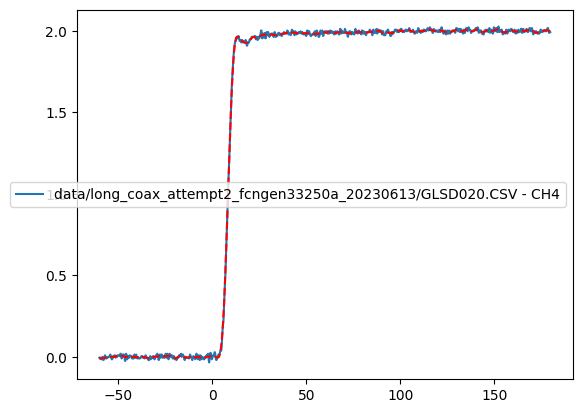

In [6]:
sys.argv[1]='data/long_coax_attempt2_fcngen33250a_20230613/GLSD020.CSV'; exec(open('make_pwl_file.py').read())

Copy [ltra_test.asc](ltra_test.asc) to [tdr_10ftrg58cu_fcngen33250a](tdr_10ftrg58cu_fcngen33250a).  Starting with this:

Had to add RT to get simulation to converge.  May need to think about that later, but got the idea from [SPICE_Simulations_Series_SQUID_Array.pdf](SPICE_Simulations_Series_SQUID_Array.pdf).

This will simulate the circuit shown for the listed RLs.

Next, run the simulation and leave the plot open.  We can then use the ltspice python library to plot our TDR measurements versus the simulation like this (can install this module with `pip3 install ltspice`):

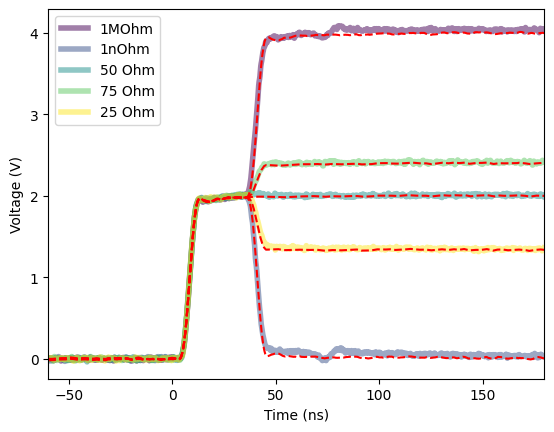

In [39]:
import ltspice

#
# Data
#
datafiles=['data/long_coax_attempt2_fcngen33250a_20230613/GLSD021.CSV',
           'data/long_coax_attempt2_fcngen33250a_20230613/GLSD022.CSV',
           'data/long_coax_attempt2_fcngen33250a_20230613/GLSD023.CSV',
           'data/long_coax_attempt2_fcngen33250a_20230613/GLSD024.CSV',
           'data/long_coax_attempt2_fcngen33250a_20230613/GLSD025.CSV']

# LTSpice trans data starts at zero, so pull the start time from the first dataset and use to offset the model data.
# assumes datasets were all taken with the same time offset.
datalabels=['1MOhm',"1nOhm","50 Ohm","75 Ohm","25 Ohm"]
mint,maxt=None,None

# Pick a nice color map
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

# Load datasets, and plot.  Also extract time offset for model.
for datalabel,datafile in zip(datalabels,datafiles):
    datadf=pd.read_csv(datafile, index_col=False)
    datadf=datadf.dropna(axis=1,how='all')
    
    t_ns=1.e9*datadf['in s'].values
    v4=datadf['C4 in V'].values
    v4=v4-np.mean(v4[:200]) # shifts starting voltage to zero to simplify plots
    plt.plot(t_ns,v4,label=f'{datalabel}',alpha=0.5,lw=4) # plot with some transparency so can overlay model
    if mint is None:
        mint=np.min(t_ns)
        maxt=np.max(t_ns)

#
# Overplot model.  LTSpice must be open and sim must have been run.
#
ascpath = 'tdr_10ftrg58cu_fcngen33250a.raw'
l = ltspice.Ltspice(ascpath)
l.parse() # Data loading sequence. It may take few minutes for huge file.

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

for i in range(l.case_count):
    time = l.get_time(i)    
    vtdr = l.get_data('V(vtdr)',i)
    plt.plot(mint+time*1.e9,2.0*vtdr,'r--') # 2x here because fcn gen outputs 2x the programmed signal in 50 Ohm mode

plt.xlabel('Time (ns)')
plt.xlim(mint,maxt)
plt.ylabel('Voltage (V)')

plt.legend()    
    
plt.xlabel('Time (ns)')
plt.xlim(mint,maxt)
plt.ylabel('Voltage (V)')

plt.legend()

Obviously not quite capturing everything., particularly the 2nd reflection.  Can we produce any of those features by changing the LTRA parameters?